# Morfología en escala de grises y segmentación mediante el método de línea divisoria de aguas.

En este tutorial exploraremos la morfología matemática en escala de grises, entendida como una generalización de la morfología binaria. Además, abordaremos la segmentación de imágenes mediante el método de línea divisoria de aguas, incluyendo mejoras basadas en la imposición de mínimos, así como un análisis de sus ventajas y desventajas.

## Morfología en escala de grises

Anteriormente revisamos las operaciones básicas de morfología binaria: dilatación, erosión, apertura y clausura. Estas operaciones se extienden al caso en escala de grises, donde las intensidades se interpretan como alturas en una representación topográfica tridimensional (x, y, intensidad).

En este contexto, los elementos estructurantes también se consideran en 3D, y las operaciones se interpretan como filtros mínimo/máximo sobre vecindades definidas por el elemento estructurante. Esto permite detectar bordes, suavizar regiones o extraer extremos locales, entre otros usos.

A lo largo del tutorial implementaremos estas operaciones y utilizaremos funciones provistas por librerías como skimage y cv2.

#### **Importante**
Las principales librerías que utilizaremos serán skimage (Scikit-Image) y cv2 (OpenCV).
skimage es fácil de usar y permite aplicar operaciones morfológicas de forma sencilla, lo que la hace útil para probar ideas rápidamente y visualizar resultados. Una de sus principales ventajas es que permite trabajar con datos en 3D, como volúmenes médicos.
Por su parte, cv2 es más rápida y eficiente para imágenes, y se utiliza mucho en aplicaciones que requieren buen rendimiento, aunque puede resultar menos clara de usar al principio. La desventaja es que no permite trabajar con datos en 3D.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from copy import deepcopy
import time

import cv2

from skimage.measure import label
from skimage.segmentation import watershed
from skimage.morphology import erosion, disk, footprint_rectangle, h_minima, reconstruction

### Dilatación y erosión en escala de grises
La erosión en escala de grises funciona de forma similar a la binaria: se toma el mínimo de la vecindad donde el elemento estructurante está activo, lo que reduce regiones brillantes y expande las oscuras.

La dilatación es la operación opuesta: se toma el máximo en esa vecindad, lo que expande las regiones brillantes y reduce las oscuras. Esto equivale a aplicar un filtro máximo.

Ambas operaciones pueden interpretarse como transformaciones topográficas, donde las intensidades de la imagen representan alturas. La diferencia entre una y otra radica en la función usada para procesar cada vecindad: min para erosión y max para dilatación.

In [2]:
def gray_morphology(image, structuring_element, operation):
    """Aplicar una operación morfológica en escala de grises a una imagen con un elemento estructurante.

    Args:
        image (ndarray): Imagen de entrada en escala de grises.
        structuring_element (ndarray): Elemento estructurante binario (valores 0 o 1).
        operation (function): Función de operación sobre la vecindad, por ejemplo np.min o np.max.

    Returns:
        ndarray: Imagen resultado.
    """
    m, n = structuring_element.shape
    a, b = (m - 1)//2, (n - 1)//2

    # Padding replicado
    image_pad = np.pad(image, ((a, a), (b, b)), mode="edge")
    
    # Inicializar imagen de salida
    result = np.zeros_like(image)
    
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            # Extraer vecindad
            window = image_pad[x:x+m, y:y+n]
            # Aplicar la operación solo donde structuring_element está encendido (structuring_element == 1)
            window_masked = window[structuring_element == 1]
            # Guardar el resultado de la operación (mínimo o máximo)
            result[x, y] = operation(window_masked)
    
    return result

En la siguiente celda podemos observar cómo la función implementada y las implementaciones de cv2 y skimage son muy parecidas.

Erosión propia: 51.56031084 segundos
Erosión cv2: 0.02473402 segundos
Erosión skimage: 0.82398272 segundos


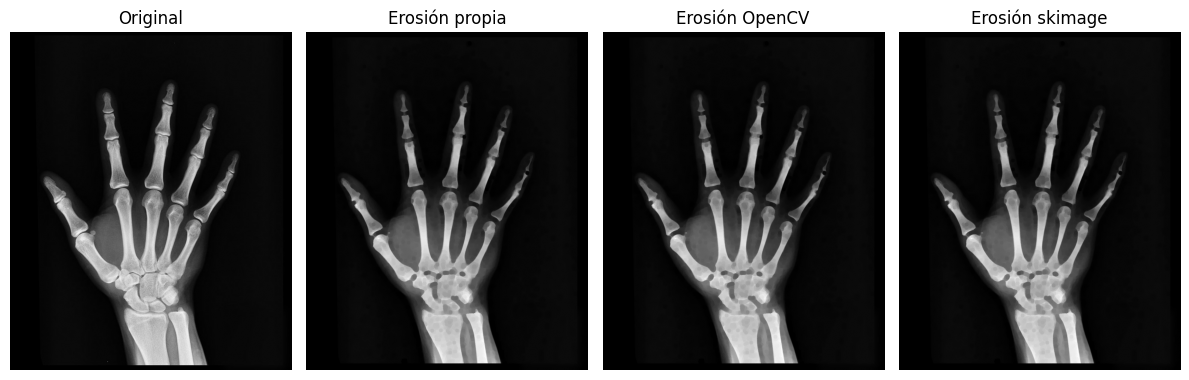

In [3]:
# Cargar imagen en escala de grises
image = cv2.imread('hand_x_ray.jpg', cv2.IMREAD_GRAYSCALE)

# Crear elemento estructurante
ee = disk(5)

# Erosión implementada manualmente
start_time = time.time()
custom_eroded = gray_morphology(image, ee, np.min)
print(f"Erosión propia: {time.time() - start_time:.8f} segundos")

# Erosión con OpenCV
start_time = time.time()
cv2_eroded = cv2.erode(image, ee.astype(np.uint8))
print(f"Erosión cv2: {time.time() - start_time:.8f} segundos")

# Erosión con skimage
start_time = time.time()
skimage_eroded = erosion(image, ee)
print(f"Erosión skimage: {time.time() - start_time:.8f} segundos")

# Visualización de resultados
images = [image, custom_eroded, cv2_eroded, skimage_eroded]
titles = ['Original', 'Erosión propia', 'Erosión OpenCV', 'Erosión skimage']

fig, ax = plt.subplots(1, 4, figsize=(12, 6))
for i in range(4):
    ax[i].imshow(images[i], cmap='gray')
    ax[i].set_title(titles[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

# Verificar que las erosiones son similares
assert np.mean(custom_eroded - skimage_eroded) < 0.01, 'La erosión propia no se parece lo suficiente a la de skimage'
assert np.mean(custom_eroded - cv2_eroded) < 0.01, 'La erosión propia no se parece lo suficiente a la de OpenCV'

### Dilatación y erosión geodésica en escala de grises

La **morfología geodésica en escala de grises** es una extensión de las operaciones morfológicas tradicionales que incorpora una imagen **máscara**, utilizada para restringir los resultados. A diferencia de las operaciones estándar, estas se realizan de manera **iterativa hasta alcanzar la convergencia**.

#### Erosión geodésica *(solo informativo)*

En la erosión geodésica, se parte de una **imagen semilla** y una **máscara** (que actúa como límite inferior). El proceso consiste en:

1. Erosionar la semilla con un elemento estructurante.
2. Calcular el **máximo pixel a pixel** entre el resultado y la máscara.
3. Repetir el proceso hasta que la imagen deje de cambiar.

Este procedimiento ajusta una erosión para que no atraviese las regiones permitidas por la máscara. Aunque no se evaluará este caso, es útil conocerlo como contraparte de la dilatación geodésica.

#### Dilatación geodésica en escala de grises

En la dilatación geodésica, se utiliza una **imagen semilla** que se expande progresivamente, pero siempre restringida por una **máscara** (límite superior). Se repite una dilatación seguida de una restricción hasta que no haya cambios.

**Procedimiento:**

1. Dilatar la semilla con un elemento estructurante.
2. Calcular el **mínimo pixel a pixel** entre el resultado y la máscara.
3. Repetir iterativamente hasta que la imagen converja.

Este tipo de operación se puede usar, por ejemplo, para **reconstrucciones morfológicas** o para **preservar estructuras específicas** en una imagen.

### Ejercicio 1

Implemente una función que realice la **dilatación geodésica** de una imagen en escala de grises, a partir de una imagen **semilla**, una **máscara** y un **elemento estructurante**.

Recomendamos utilizar funciones básicas de librerías como:

- `cv2.dilate`
- `np.minimum`, `np.maximum` (para restricciones pixel a pixel)


In [ ]:
def dilatacion_geodesica_gray(seed,mask,E1,max_iterations):
    """Realiza la dilatación geodésica en escala de grises.

    Args:
        seed (ndarray): Imagen semilla que se irá dilatando.
        mask (ndarray): Imagen máscara que actúa como límite superior.
        E1 (ndarray): Elemento estructurante para la dilatación (debe ser uint8).
        max_iterations (int): Número máximo de iteraciones.

    Returns:
        ndarray: Imagen resultante tras la dilatación geodésica.
        int: Número de iteraciones realizadas hasta converger.
    """
    semilla = seed.copy()
    
    for i in range(max_iterations):
        # 1. Dilatar la imagen semilla
        dilatada = cv2.dilate(semilla, E1)

        # 2. Restringir por la máscara
        nueva = np.minimum(dilatada, mask)

        # 3. Verificar si no hay cambios
        if np.array_equal(nueva, semilla):
            return nueva, i + 1  # convergió en i+1 iteraciones

        semilla = nueva
    return semilla, max_iterations

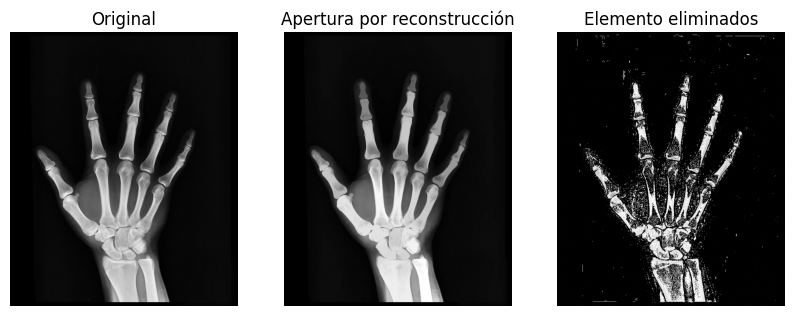

In [5]:
image=cv2.imread('hand_x_ray.jpg', cv2.IMREAD_GRAYSCALE)

# Realizar la dilatación geodésica con un elemento estructurante de disco y un máximo de 100 iteraciones
results=dilatacion_geodesica_gray(cv2.erode(image,disk(10)),image,disk(1),100)

assert type(results) is tuple, 'El resultado debe ser una tupla con clausura e iteraciones'
assert len(results) == 2, 'El resultado debe ser una tupla con clausura e iteraciones' 
clausura, iteraciones = results
# Calcular los elementos eliminados
remove_elements=1-(image-clausura)

fig,ax=plt.subplots(1,3,figsize=(10,10))

ax[0].imshow(image, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Original')
ax[1].imshow(clausura, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Apertura por reconstrucción')
ax[2].imshow(remove_elements, cmap='gray')
ax[2].axis('off')
ax[2].set_title('Elemento eliminados')
plt.show()

assert np.array_equal(np.max([erosion(clausura),image],axis=0),clausura) or iteraciones==100, 'Seguramente salió antes de tiempo del while'
assert np.isclose(np.sum(remove_elements),16986122,0.01), 'Los minimos obtenidos por la erosión por reconstrucción son erroneos'

## Segmentación mediante linea divisoria de aguas (Watersheds)

El algoritmo de Watersheds interpreta la imagen como una topografía, donde los valores de intensidad representan alturas. A partir de esta analogía, la segmentación se realiza simulando una inundación desde los mínimos locales de la imagen, que representan las cuencas.

Los pasos principales son:

1. Calcular el gradiente de la imagen, donde las intensidades más altas marcan los bordes de las estructuras.

2. Identificar los mínimos locales como puntos de inicio de la inundación.

3. Expandir iterativamente cada cuenca mediante dilatación morfológica.

4. Las regiones donde colisionan las expansiones de distintas cuencas forman las líneas divisorias o watersheds.

Este método permite separar automáticamente regiones basadas en la topología de la imagen. A continuación, lo aplicaremos para segmentar estructuras óseas en una radiografía de mano.

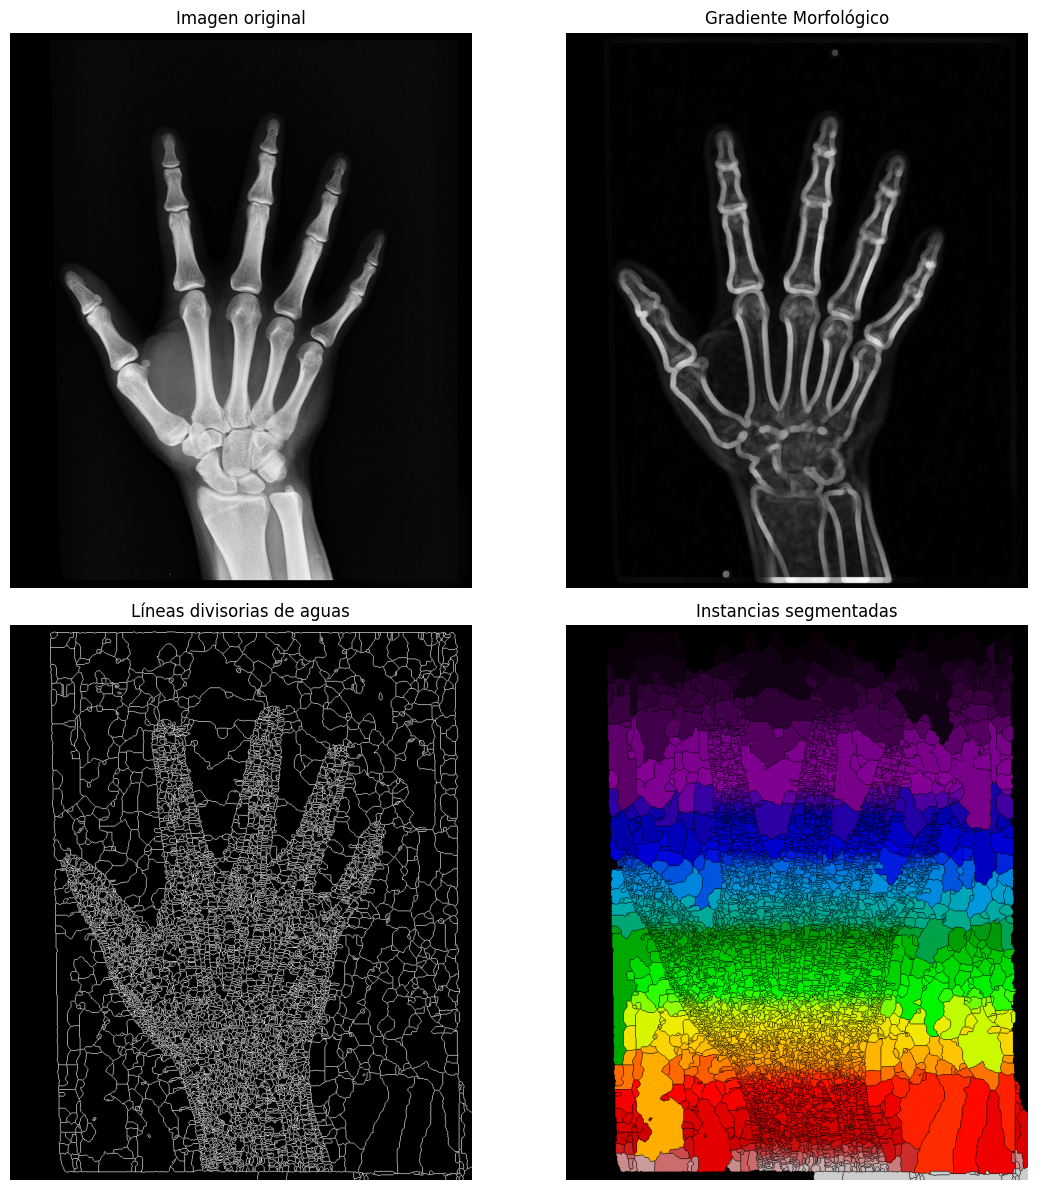

In [6]:
# Cargar la imagen en escala de grises
hand_image = cv2.imread("hand_x_ray.jpg", cv2.IMREAD_GRAYSCALE)

# Convertir a float para cálculos
hand_image = hand_image.astype(np.float32)

# Gradiente morfológico con OpenCV
ee = disk(radius=5)  # Aproximadamente radio 5
dil_hand = cv2.dilate(hand_image, ee)
ero_hand = cv2.erode(hand_image, ee)
morph_grad = dil_hand - ero_hand

seg_1 = watershed(morph_grad, markers=None, watershed_line=True)
lines_1 = seg_1 == 0

# Visualización
plt.figure(figsize=(12, 12))

plt.subplot(221)
plt.title("Imagen original")
plt.imshow(hand_image, cmap='gray')
plt.axis("off")

plt.subplot(222)
plt.title("Gradiente Morfológico")
plt.imshow(morph_grad, cmap='gray')
plt.axis("off")

plt.subplot(223)
plt.title("Líneas divisorias de aguas")
plt.imshow(lines_1, cmap='gray')
plt.axis("off")

plt.subplot(224)
plt.title("Instancias segmentadas")
plt.imshow(seg_1, cmap='nipy_spectral')
plt.axis("off")

plt.tight_layout()
plt.show()


Note que la segmentación produce demasiadas regiones. Esto se debe a la gran cantidad de mínimos locales en el gradiente, lo que genera sobre-segmentación. Un mínimo local es un píxel más oscuro que sus vecinos, y en imágenes reales, el ruido puede generar muchos de ellos.

Para evitar esto, se puede imponer mínimos, es decir, forzar que solo ciertos píxeles sean considerados como puntos de inicio para la inundación. Una forma de lograrlo es usando el algoritmo de h-mínimos, que elimina mínimos poco profundos y ayuda a controlar cuántas regiones se segmentan.

### Watershed con h-mínimos

El algoritmo de **h-mínimos** se utiliza para seleccionar automáticamente los marcadores que se emplean en la segmentación por *watershed*. Esta técnica permite controlar el número de regiones segmentadas al eliminar los mínimos poco profundos que pueden conducir a una sobre-segmentación.

Un **h-mínimo** se define como un mínimo local cuya profundidad (es decir, la diferencia de intensidad respecto a sus alrededores) es mayor o igual a un valor *h*. Al conservar solo los mínimos más significativos, el algoritmo produce marcadores más robustos para la segmentación.

En la práctica, este enfoque se implementa de la siguiente forma:

- Se calcula el **gradiente morfológico** de la imagen, usando la diferencia entre la dilatación y la erosión con un disco de radio 1.
- Se detectan los **h-mínimos** sobre el gradiente, por ejemplo, utilizando `skimage.morphology.h_minima`.
- Los mínimos se etiquetan mediante `skimage.measure.label` para generar los **marcadores**.
- Se aplica el algoritmo de **watershed**, utilizando estos marcadores. Es recomendable desactivar la opción `watershed_line` para obtener bordes más suaves y definidos.

Este procedimiento permite reducir la sensibilidad a detalles menores y producir segmentaciones más estables.

In [7]:
def watershed_h_minimos(image, h):
    """Segmentación mediante watershed con h-mínimos.

    Args:
        image (ndarray): Imagen a segmentar.
        h (float): Valor de profundidad para calcular los h-mínimos.

    Returns:
        ndarray: Segmentación resultante.
    """
    dil_hand = cv2.dilate(image, disk(radius=1))
    ero_hand = cv2.erode(image, disk(radius=1))
    morph_grad = dil_hand - ero_hand
    h_minima_ = h_minima(morph_grad, h) 
    unique_markers = label(h_minima_)
    seg = watershed(morph_grad, markers=unique_markers, watershed_line=False)
    return seg
    

(np.float64(-0.5), np.float64(767.5), np.float64(922.5), np.float64(-0.5))

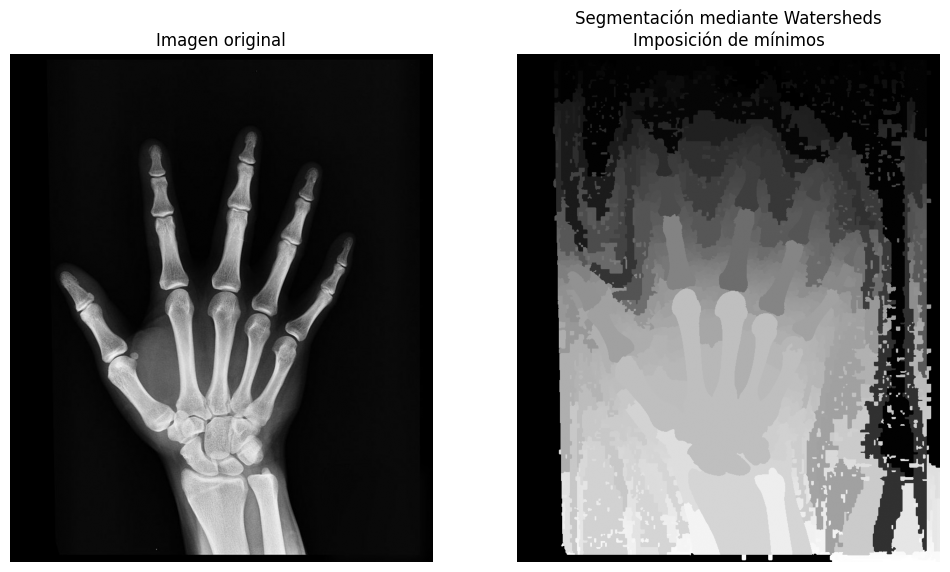

In [8]:
# Cargar la imagen en escala de grises
hand_image = cv2.imread("hand_x_ray.jpg", cv2.IMREAD_GRAYSCALE)

seg = watershed_h_minimos(hand_image, h = 60)

assert len(np.unique(seg)) == 2097, f'La segmentación debería tener 2097 segmentos no {len(np.unique(seg))}'
assert np.isclose(np.sum(seg), 596558637, 0.01), f'No realizo watershed mediante imposición de mínimos correctamente'

plt.figure(figsize=(12,12))

plt.subplot(121)
plt.title("Imagen original")
plt.imshow(hand_image, cmap = 'gray')
plt.axis("Off")

plt.subplot(122)
plt.title("Segmentación mediante Watersheds\nImposición de mínimos")
plt.imshow(seg, cmap = 'gray')
plt.axis("Off")

### Imposición de mínimos

Finalmente, revisemos el algoritmo de **imposición de mínimos**, útil cuando se desea guiar una segmentación utilizando **mínimos marcados manualmente**.

A continuación, presentamos una descripción paso a paso del algoritmo que implementaremos:

1. Crear un arreglo marcador con los mismos valores de la imagen original, pero donde **todos los valores sean \(+\infty\)**.
2. En el marcador, establecer a **cero** las posiciones correspondientes a los **mínimos impuestos** (por ejemplo, dadas por una máscara booleana).
3. Crear una máscara intermedia sumando 1 a la imagen original y tomando el **mínimo punto a punto** entre esta imagen modificada y el marcador.
4. Aplicar una **erosión geodésica** entre el marcador y la máscara resultante.

#### Ejercicio 2

Implementa una función que reciba:

- Una imagen original (`np.ndarray`).
- Una máscara booleana del mismo tamaño (`np.ndarray[bool]`) indicando las posiciones de los mínimos que se quieren imponer.

La función debe devolver el resultado de aplicar el algoritmo de imposición de mínimos descrito anteriormente.

**Recomendaciones:**  
- Pueden utilizar la función `reconstruction` del módulo `skimage.morphology` para realizar la erosión geodésica.  
- Asegúrense de que el arreglo marcador tenga tipo de dato `float`, ya que la función lo requiere para un funcionamiento correcto.
- Pueden utilizar `skimage.morphology.footprint_rectangle` para crear un elemento estructurante cuadrado de tamaño 3×3, que servirá como `footprint` en la erosión geodésica.

In [ ]:
def minima_imposition(img, minima_mask):
    """
    Impone mínimos en una imagen o señal 1D o 2D usando reconstrucción morfológica por erosión.

    Parámetros:
        img: np.ndarray (2D)
            Imagen o señal sobre la cual imponer mínimos.
        minima_mask: np.ndarray (bool)
            Máscara booleana o binaria con True en las posiciones donde se imponen mínimos.

    Retorna:
        np.ndarray: imagen con mínimos impuestos.
    """
    img = img.astype(float)

    # Paso 1: Crear el marcador lleno de +inf
    marker = np.full_like(img, np.inf, dtype=float)

    # Paso 2: Donde hay mínimos impuestos, poner 0
    marker[minima_mask] = 0.0

    # Paso 3: Construir la máscara intermedia
    mask = np.minimum(img + 1, marker)

    # Paso 4: Erosión geodésica
    final = reconstruction(marker, mask, method='erosion', footprint=footprint_rectangle((3, 3)))

    return final

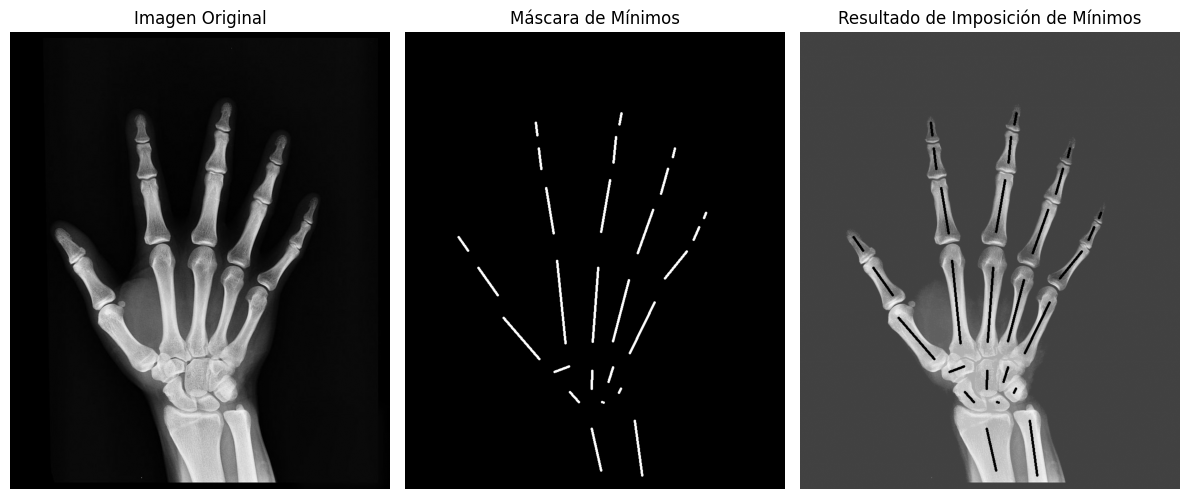

In [12]:
# Cargar la imagen en escala de grises
hand_image = cv2.imread("hand_x_ray.jpg", cv2.IMREAD_GRAYSCALE)
# Cargar la imagen de los marcadores
binary_image = cv2.imread('hand_x_ray_markers.jpg', cv2.IMREAD_GRAYSCALE) >= 200

# Imponer mínimos en la imagen de rayos X de la mano
# utilizando la imagen de marcadores como máscara
minima_imposition_result = minima_imposition(hand_image, binary_image)

assert np.isclose(np.sum(minima_imposition_result), 57370965, 0.01), 'La suma de los píxeles del resultado de la imposición de mínimos es incorrecta'
assert np.isclose(np.sum(minima_imposition_result[binary_image]), 0, 0.01), 'Las áreas de los marcadores no deberían contener valores'
assert np.sum(minima_imposition_result[~binary_image]) > 0, 'Las áreas fuera de los marcadores deberían contener valores'

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(hand_image, cmap='gray')
ax[0].set_title('Imagen Original')
ax[0].axis('off')
ax[1].imshow(binary_image, cmap='gray')
ax[1].set_title('Máscara de Mínimos')
ax[1].axis('off')
ax[2].imshow(minima_imposition_result, cmap='gray')
ax[2].set_title('Resultado de Imposición de Mínimos')
ax[2].axis('off')
plt.tight_layout()
plt.show()

## Créditos ##

Danniel Moreno - Jose Miguel Abril Nova - Santiago Usma - Juan Camilo Lyons - Felipe Escallón Páez - Jose Miguel Abril Nova